 Этап 1. Генерация данных
 
 Изучите набор данных, располагающийся в архиве blood_cells.
 
 Выполните "нарезку" изображений. Сохраните в отдельные папки изображения фона и изображения клеток.
 
 Реализуйте генератор данных снимков клеток крови. На выходе генератор предосталвяет два изображения: сгенерированное без шума, сгенерированное с шумом.
 
 Патчи для формирования фона: 
 
 1) патчи, вырезанные из исходного набора данных 
 
 2) искусственно сформированные патчи (равномерная заливка фона из диапазона допустимых значений)
 
 Фон изображения формируется из набора патчей. 
 
 Патчи для клеток крови:
 
 1) патчи, вырезанные из исходного набора данных
 
 2) искусствено сгенерированные окружности с заливкой из допустимого набора данных
 
 для blending-задачи применять: https://learnopencv.com/seamless-cloning-using-opencv-python-cpp/
 
 Примеры генераторов и загрузчиков данных найдете в исходной папке.

 Основные этапы генерации:
 
 1. Выбор, формирование патчей, их препроцессинг. Формирование(комбинирование) фона из набора патчей. Постпроцессинг результирующего фона.
 
 2. Выбор метоположения клекток, выбор/формирование клеток, совмещение клеток на фоновом изображении
 
 3. Выбор типа шума. Зашумление изображения. 

 Генератор возвращает два изображения: зашумленное (этап 3) и исходное (этап 2) изображения.


In [2]:
import cv2
import os
import numpy as np
from glob import glob

PATCH_SIZE = (64, 64)
MIN_CELL_SIZE = 30

def crop_background_patches(image_paths, mask_paths, output_dir, patch_size=PATCH_SIZE):
    os.makedirs(output_dir, exist_ok=True)
    count = 0
    for image_path, mask_path in zip(image_paths, mask_paths):
        img = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        h, w = img.shape[:2]
        for i in range(0, h - patch_size[1] + 1, patch_size[1] // 2):
            for j in range(0, w - patch_size[0] + 1, patch_size[0] // 2):
                patch = img[i:i + patch_size[1], j:j + patch_size[0]]
                mask_patch = mask[i:i + patch_size[1], j:j + patch_size[0]]
                if np.any(mask_patch > 0):
                    continue
                output_path = os.path.join(output_dir, f"background_patch_{count}.png")
                cv2.imwrite(output_path, patch)
                count += 1
    print(f"Сохранено {count} патчей фона")


def crop_cell_patches_with_masks(image_paths, mask_paths, output_dir, patch_size=PATCH_SIZE, min_cell_size=MIN_CELL_SIZE):
    os.makedirs(output_dir, exist_ok=True)
    count = 0
    for image_path, mask_path in zip(image_paths, mask_paths):
        img = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w < min_cell_size or h < min_cell_size:
                continue
            patch = img[y:y + h, x:x + w]
            if patch.shape[0] == 0 or patch.shape[1] == 0:
                continue
            if patch.shape[0] < patch_size[1] or patch.shape[1] < patch_size[0]:
                patch = cv2.resize(patch, patch_size, interpolation=cv2.INTER_AREA)
            output_path = os.path.join(output_dir, f"cell_patch_{count}.png")
            cv2.imwrite(output_path, patch)
            count += 1
    print(f"Сохранено {count} патчей")

image_dir = r"blood_cells_dataset\original"
mask_dir = r"blood_cells_dataset\mask"
output_cells_dir = "data/cells"
output_background_dir = "data/background"
image_paths = glob(os.path.join(image_dir, "*"))
mask_paths = glob(os.path.join(mask_dir, "*"))

print("Нарезка изображений клеток")
crop_cell_patches_with_masks(image_paths, mask_paths, output_cells_dir)
print("Нарезка изображений фона")
crop_background_patches(image_paths, mask_paths, output_background_dir)

Нарезка изображений клеток
Сохранено 3692 патчей
Нарезка изображений фона
Сохранено 31544 патчей фона


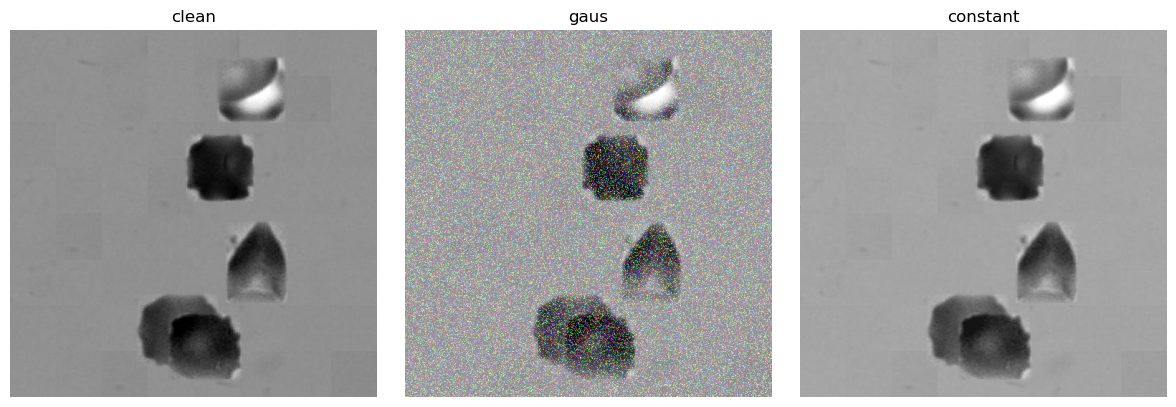

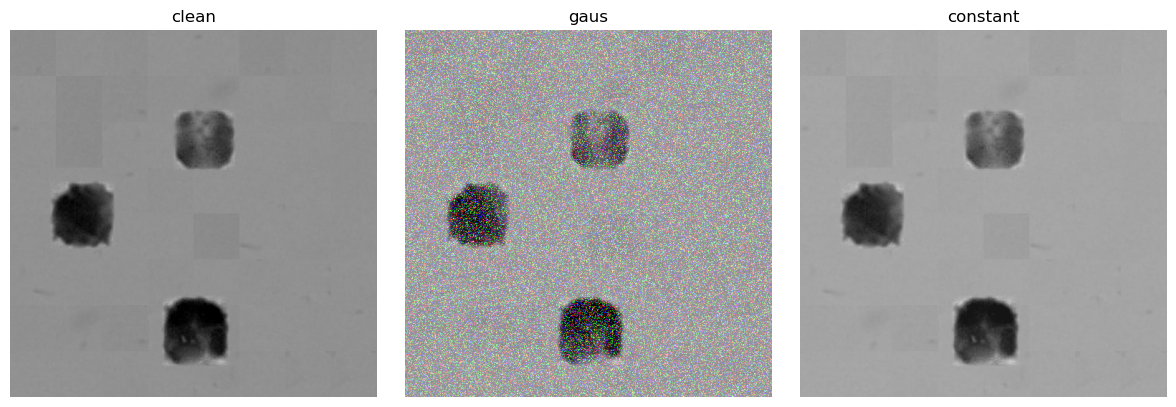

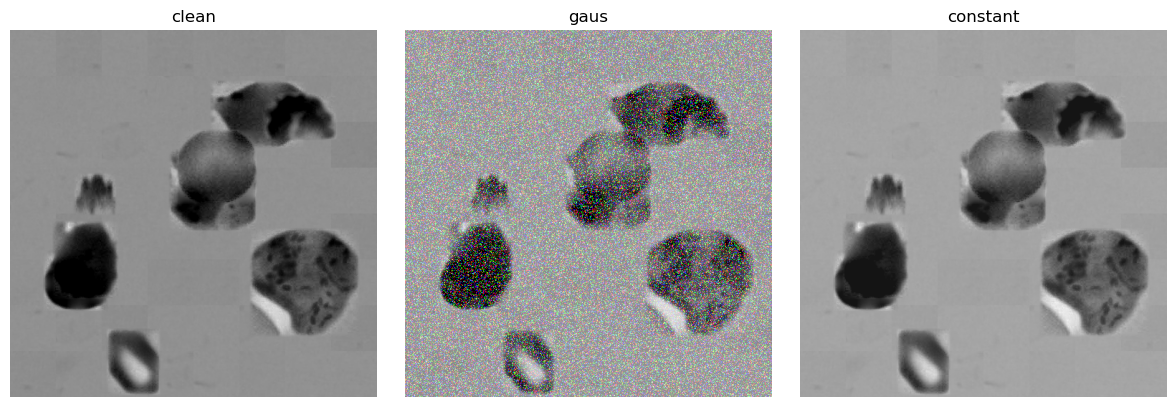

In [2]:
import cv2
import numpy as np
import random
import os
from glob import glob
import matplotlib.pyplot as plt


IMAGE_SIZE = (512, 512)
NUM_CELLS_RANGE = (2, 10)

def create_background_from_patches(image_size=IMAGE_SIZE, patch_dir="data/background"):
    background = np.zeros((image_size[1], image_size[0], 3), dtype=np.uint8)
    patch_size = (64, 64)
    patch_files = glob(os.path.join(patch_dir, "*.png"))
    num_patches_x = image_size[0] // patch_size[0]
    num_patches_y = image_size[1] // patch_size[1]

    for i in range(num_patches_y):
        for j in range(num_patches_x):
            patch = cv2.imread(random.choice(patch_files), cv2.IMREAD_GRAYSCALE)
            if patch is None:
                print(f"Error loading patch from {patch_files[0]}")
                continue
            patch = cv2.cvtColor(patch, cv2.COLOR_GRAY2BGR)
            background[i * patch_size[1]:(i + 1) * patch_size[1], j * patch_size[0]:(j + 1) * patch_size[0]] = patch

    return background  


def place_cell(background, cell):
    bg_h, bg_w, _ = background.shape
    cell_h, cell_w, _ = cell.shape
    mask = 255 * np.ones((cell_h, cell_w), dtype=np.uint8)  
    x = random.randint(0, bg_w - cell_w)
    y = random.randint(0, bg_h - cell_h)
    center = (x + cell_w // 2, y + cell_h // 2)  
    background = cv2.seamlessClone(cell, background, mask, center, cv2.NORMAL_CLONE)
    return background


def add_gaussian_noise(image, mean=0, sigma=1):
    noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image


def add_constant_noise(image, value=20):
    noisy_image = cv2.add(image, value)
    return noisy_image


def data_generator(cell_patch_dir="data/cells", use_generated_circles=True):
    while True:
        background = create_background_from_patches()
        clean_image = background.copy()
        num_cells = random.randint(NUM_CELLS_RANGE[0], NUM_CELLS_RANGE[1])
        cell_files = glob(os.path.join(cell_patch_dir, "*.png"))
        for _ in range(num_cells):
            cell = cv2.imread(random.choice(cell_files), cv2.IMREAD_GRAYSCALE)
            cell = cv2.cvtColor(cell, cv2.COLOR_GRAY2BGR)
            bg_h, bg_w, _ = clean_image.shape
            cell_h, cell_w, _ = cell.shape
            x = random.randint(0, bg_w - cell_w)
            y = random.randint(0, bg_h - cell_h)
            clean_image = place_cell(clean_image, cell)
        noisy_gaus_image = add_gaussian_noise(clean_image.copy())
        noisy_constant_image = add_constant_noise(clean_image.copy())
        yield noisy_gaus_image, noisy_constant_image, clean_image


generator = data_generator()
for i in range(3):
    noisy_gaus_image, noisy_constant_image, clean_image = next(generator)
    cv2.imwrite(f"noisy_gaus_image_{i}.png", noisy_gaus_image)
    cv2.imwrite(f"noisy_constant_image{i}.png", noisy_constant_image)
    cv2.imwrite(f"clean_image_{i}.png", clean_image)

    plt.figure(figsize=(12, 4))  # Создаем фигуру, задаем размер
    plt.subplot(1, 3, 1)  # 1 строка, 3 столбца, первый график
    plt.imshow(clean_image, cmap='gray')
    plt.title("clean")
    plt.axis('off')

    plt.subplot(1, 3, 2)  # 1 строка, 3 столбца, второй график
    plt.imshow(noisy_gaus_image, cmap='gray')
    plt.title("gaus")
    plt.axis('off')

    plt.subplot(1, 3, 3)  # 1 строка, 3 столбца, третий график
    plt.imshow(noisy_constant_image, cmap='gray')
    plt.title("constant")
    plt.axis('off')

    plt.tight_layout()  # Автоматическая настройка отступов между графиками
    plt.show()

#Этап 2. Исследование качества работы алгоритмов шумоподавления на сформированном датасете.
 
 Виды шумов:
 
 1) Шум Гаусса
 
 2) постоянный шум
 
 Виды фильтров:
 
 1) Медианный фильтр
 
 2) фильтр гаусса
 
 3) билатериальный фильтр 
 
 4) фильтр нелокальных средних с различными параметрами.
 
 5.1) самостоятелная реализация алгоритма шумоподавления (CPU)
 
 5.2) самостоятелная реализация алгоритма шумоподавления (GPU)
 
 Метрики:
 
 1) MSE
 
 2) SSIM
 
 3) время работы
 

In [22]:
from glob import glob
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import time

def apply_median_filter(image, kernel_size=3):
    return cv2.medianBlur(image, kernel_size)

def apply_gaussian_filter(image, kernel_size=(5, 5), sigmaX=0):
    return cv2.GaussianBlur(image, kernel_size, sigmaX)

def apply_bilateral_filter(image, d=9, sigmaColor=75, sigmaSpace=75):
    return cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)

def apply_nlmeans_filter(image, h=10, templateWindowSize=7, searchWindowSize=21):
    return cv2.fastNlMeansDenoising(image, h=h, templateWindowSize=templateWindowSize, searchWindowSize=searchWindowSize)

def calculate_mse(image1, image2):
    return mean_squared_error(image1, image2)

def calculate_ssim(image1, image2):
    return ssim(image1, image2, data_range=image1.max() - image1.min())

def evaluate_filter(clean_image, noisy_image, filter_function, **kwargs):
    start_time = time.time()
    denoised_image = filter_function(noisy_image.copy(), **kwargs)
    end_time = time.time()
    mse = calculate_mse(clean_image, denoised_image)
    ssim_value = calculate_ssim(clean_image, denoised_image)
    execution_time = end_time - start_time
    return {
        "MSE": mse,
        "SSIM": ssim_value,
        "time": execution_time
    }

def generate_test_images(index):
    noisy_gaus_images = glob(os.path.join("noisy_gaus_image_*.png"))
    noisy_constant_images = glob(os.path.join("noisy_constant_image*.png"))
    clean_images = glob(os.path.join("clean_image_*.png"))
    #index = random.randint(0, min(len(noisy_gaus_images), len(noisy_constant_images), len(clean_images)) - 1)
    noisy_gaus_image_path = noisy_gaus_images[index]
    noisy_constant_image_path = noisy_constant_images[index]
    clean_image_path = clean_images[index]
    noisy_gaus_image = cv2.imread(noisy_gaus_image_path, cv2.IMREAD_GRAYSCALE)
    noisy_constant_image = cv2.imread(noisy_constant_image_path, cv2.IMREAD_GRAYSCALE)
    clean_image = cv2.imread(clean_image_path, cv2.IMREAD_GRAYSCALE)
    return noisy_gaus_image, noisy_constant_image, clean_image

    
for i in range(3):
    noisy_gaus_image, noisy_constant_image, clean_image = generate_test_images(i)
    median_results_gaus[i] = evaluate_filter(clean_image, noisy_gaus_image, apply_median_filter, kernel_size=3)
    gaussian_results_gaus[i] = evaluate_filter(clean_image, noisy_gaus_image, apply_gaussian_filter, kernel_size=(5, 5), sigmaX=0)
    bilateral_results_gaus[i] = evaluate_filter(clean_image, noisy_gaus_image, apply_bilateral_filter)
    nlmeans_results_gaus[i] = evaluate_filter(clean_image, noisy_gaus_image, apply_nlmeans_filter)
    median_results_const[i] = evaluate_filter(clean_image, noisy_constant_image, apply_median_filter, kernel_size=3)
    gaussian_results_const[i] = evaluate_filter(clean_image, noisy_constant_image, apply_gaussian_filter, kernel_size=(5, 5), sigmaX=0)
    bilateral_results_const[i] = evaluate_filter(clean_image, noisy_constant_image, apply_bilateral_filter)
    nlmeans_results_const[i] = evaluate_filter(clean_image, noisy_constant_image, apply_nlmeans_filter)
    
print("Оценка фильтров для шума Гаусса:")
print(f"Медианный фильтр: MSE={sum(median_results_gaus[i]['MSE']/3 for i in range(3)):.4f}, SSIM={sum(median_results_gaus[0]['SSIM']/3 for i in range(3)):.4f}, Time={sum(median_results_gaus[0]['time']/3 for i in range(3)):.4f}")
print(f"Фильтр Гаусса: MSE={sum(gaussian_results_gaus['MSE']/3 for i in range(3)):.4f}, SSIM={sum(gaussian_results_gaus['SSIM']/3 for i in range(3)):.4f}, Time={sum(gaussian_results_gaus['time']/3 for i in range(3)):.4f}")
print(f"Билатеральный фильтр: MSE={sum(bilateral_results_gaus['MSE']/3 for i in range(3)):.4f}, SSIM={sum(bilateral_results_gaus['SSIM']/3 for i in range(3)):.4f}, Time={sum(bilateral_results_gaus['time']/3 for i in range(3)):.4f}")
print(f"NL-means фильтр: MSE={sum(nlmeans_results_gaus['MSE']/3 for i in range(3)):.4f}, SSIM={sum(nlmeans_results_gaus['SSIM']/3 for i in range(3)):.4f}, Time={sum(nlmeans_results_gaus['time']/3 for i in range(3)):.4f}")

print()
print("Оценка фильтров для постоянного шума:")
print(f"Медианный фильтр: MSE={sum(median_results_const['MSE']/3 for i in range(3)):.4f}, SSIM={sum(median_results_const['SSIM']/3 for i in range(3)):.4f}, Time={sum(median_results_const['time']/3 for i in range(3)):.4f}")
print(f"Фильтр Гаусса: MSE={sum(gaussian_results_const['MSE']/3 for i in range(3)):.4f}, SSIM={sum(gaussian_results_const['SSIM']/3 for i in range(3)):.4f}, Time={sum(gaussian_results_const['time']/3 for i in range(3)):.4f}")
print(f"Билатеральный фильтр: MSE={sum(bilateral_results_const['MSE']/3 for i in range(3)):.4f}, SSIM={sum(bilateral_results_const['SSIM']/3 for i in range(3)):.4f}, Time={sum(bilateral_results_const['time']/3 for i in range(3)):.4f}")
print(f"NL-means фильтр: MSE={sum(nlmeans_results_const['MSE']/3 for i in range(3)):.4f}, SSIM={sum(nlmeans_results_const['SSIM']/3 for i in range(3)):.4f}, Time={sum(nlmeans_results_const['time']/3 for i in range(3)):.4f}")

Оценка фильтров для шума Гаусса:
Медианный фильтр: MSE=204.6926, SSIM=0.4574, Time=0.0000
Фильтр Гаусса: MSE=533.2863, SSIM=0.5213, Time=0.0011
Билатеральный фильтр: MSE=469.8326, SSIM=0.6230, Time=0.0100
NL-means фильтр: MSE=1515.0408, SSIM=0.0918, Time=0.3166

Оценка фильтров для постоянного шума:
Медианный фильтр: MSE=402.2205, SSIM=0.9473, Time=0.0000
Фильтр Гаусса: MSE=402.8456, SSIM=0.9431, Time=0.0000
Билатеральный фильтр: MSE=407.8375, SSIM=0.9154, Time=0.0050
NL-means фильтр: MSE=406.4707, SSIM=0.9125, Time=0.6262
